# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:13<00:00, 4.59kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

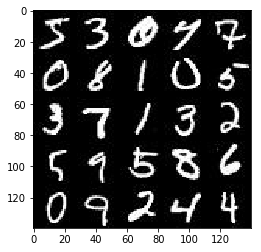

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

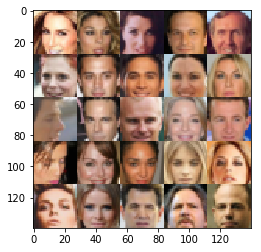

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/solomongebreyohannes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    ilearning_rate = tf.placeholder(tf.float32, name='learning_rate')    
    
    return inputs_real, inputs_z, ilearning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function 
    with tf.variable_scope('discriminator', reuse=reuse): 
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) 
        # 14x14x64 
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True) 
        relu2 = tf.maximum(alpha * bn2,  bn2) 
        # 7x7x128 
        
        # Flatten it 
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """ 
     
    # TODO: Implement Function 
    alpha=0.2  
    with tf.variable_scope('generator', reuse=not is_train): 
        
        # First layer 
        x1 = tf.layers.dense(z, 7*7*256) 
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) 
        # 7x7x256 
        
        # Second layer 
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train) 
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 
        
        # Output layer 
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same') 
        # 28x28xout_channel_dim 
        
        out = tf.tanh(logits)    
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function 
    
    g_model = generator(input_z, out_channel_dim) 
    d_model_real, d_logits_real = discriminator(input_real) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) 
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model 
    _, image_width, image_height, image_channels = data_shape
            
    input_real, input_z, ilearning_rate = model_inputs(image_width, image_height, image_channels, z_dim)  
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)  
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 
    
    print_every=10 
    show_every=100 
    # figsize=(5,5) 
    saver = tf.train.Saver() 
    steps = 0
    n_images = 25    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model 
                steps += 1 
                batch_images *= 2 
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, ilearning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6782... Generator Loss: 0.2645
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.3101
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.4523
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.4477
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.4789
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.7141


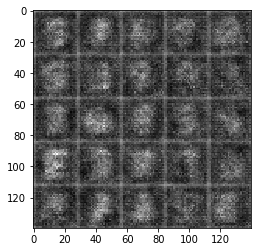

Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.1275
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.0894
Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 1.1396
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 1.2375
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.2889


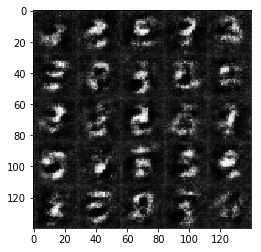

Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.4535
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.5817
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.5850
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 0.8227


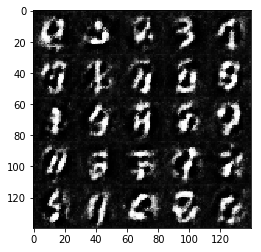

Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 0.8195
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 1.1626
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.0228
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 0.9395


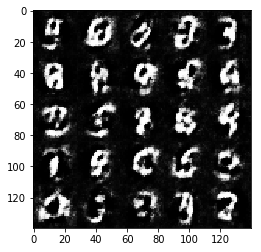

Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 1.2036
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 1.1050
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.1161
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 1.0993


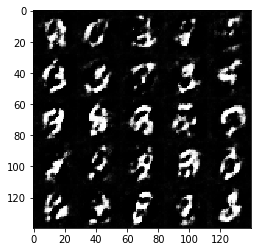

Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 1.1913


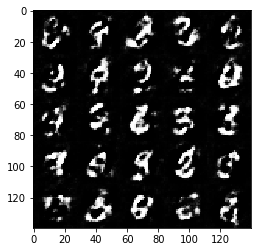

Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.9746
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 0.8464
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 1.0091
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.9567
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 0.5282
Epoch 1/2... Discriminator Loss: 0.9643... Generator Loss: 1.0621


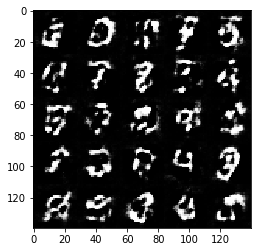

Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 0.9072
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 1.1759
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.1281
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.6369


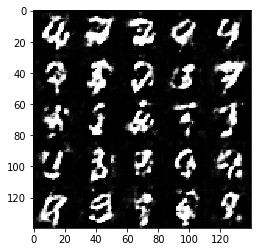

Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 1.2809
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 1.0074
Epoch 1/2... Discriminator Loss: 0.8587... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 0.9473


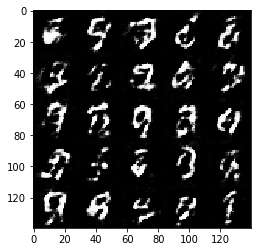

Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 1.1885
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.2404
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 1.2518
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.0797
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.2292


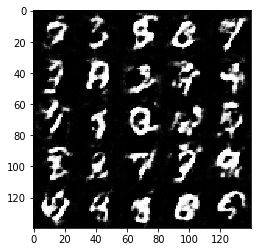

Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.2713
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.4503
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 0.7480


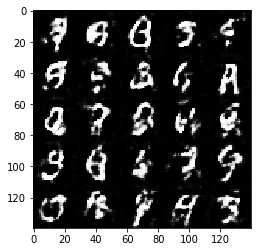

Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 0.8502... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 0.8374
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.2589
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 0.8331


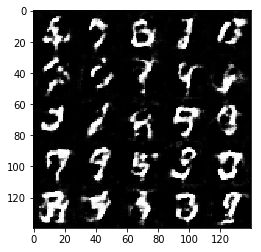

Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 1.6997
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 0.9195
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.2075
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 1.2019
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.4986
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.6083
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.0662
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.7686


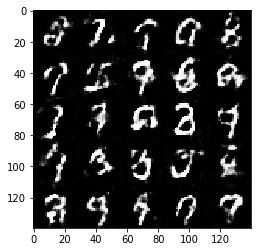

Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.2742
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 1.3193
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.0264
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 0.7412


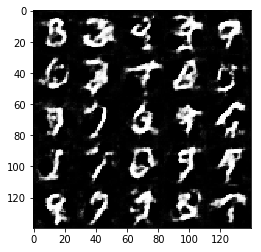

Epoch 2/2... Discriminator Loss: 1.3160... Generator Loss: 0.3983
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 1.3442
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.1293
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.0603


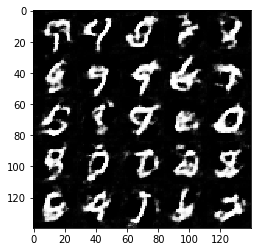

Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 1.0456
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 0.8146
Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.4441


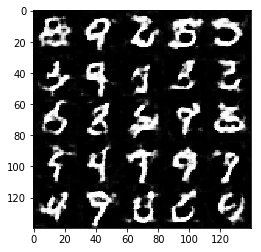

Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 1.0234... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.1064... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 1.1702
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 0.6385


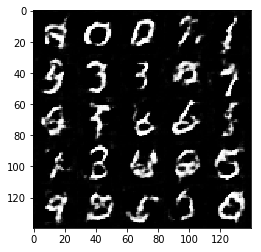

Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 1.3936
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 1.3491
Epoch 2/2... Discriminator Loss: 1.0300... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.0855
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.3929
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 1.2308


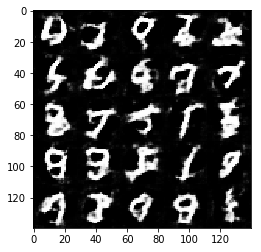

Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.6814


In [29]:
batch_size = 64
z_dim = 200        
learning_rate = 0.00008   
beta1 = 0.1   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1974... Generator Loss: 0.1712
Epoch 1/1... Discriminator Loss: 2.2657... Generator Loss: 0.1684
Epoch 1/1... Discriminator Loss: 1.8180... Generator Loss: 0.2720
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.0458


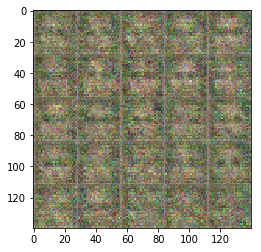

Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.5481
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 0.9599


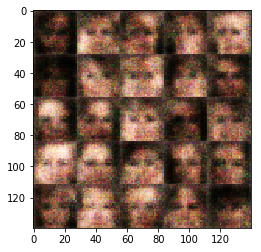

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.6281


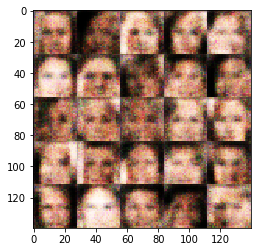

Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.5904
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.0451


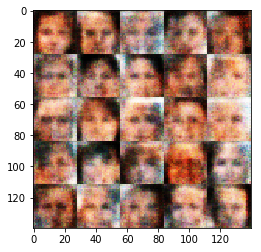

Epoch 1/1... Discriminator Loss: 1.8338... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.1762


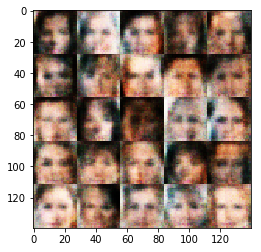

Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.5251


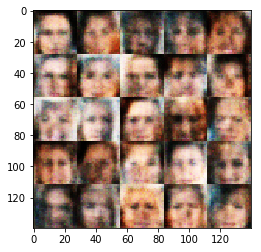

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.7013
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.4675


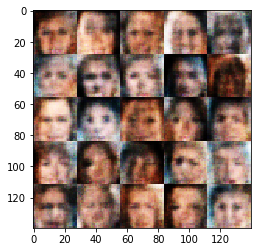

Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.3381


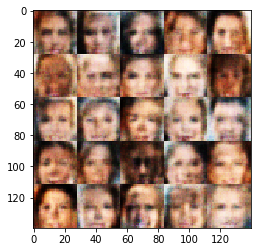

Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.9023


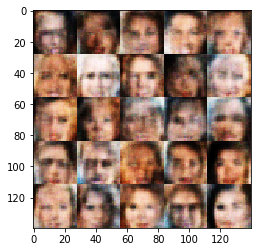

Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.5340


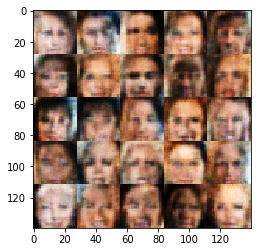

Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.6395


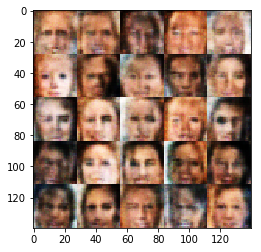

Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 2.3484
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.9530
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.8325
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.3625
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.6286
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.6725
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.5605


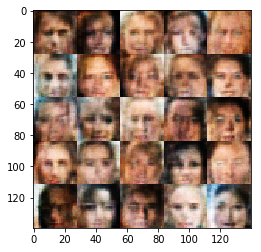

Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.6275
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 2.0755
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.7037
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.4448


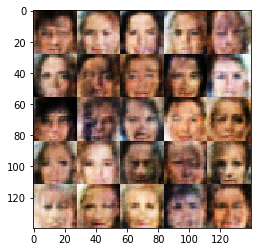

Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 2.1664
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 2.1865
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.7094
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 1.7023
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 1.6264
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.4186
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.5796


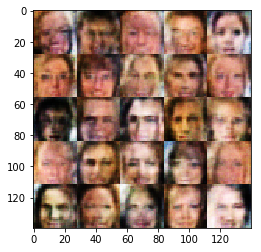

Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.8940
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.6643
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.8666
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.7990
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 1.8580
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.1041


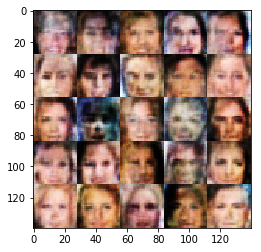

Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 2.2615
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 2.1033
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 2.0296
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.9077


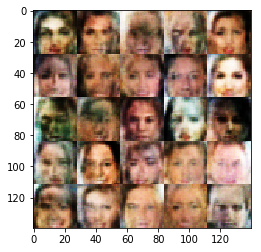

Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.5349
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.5453
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.8425
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.2849


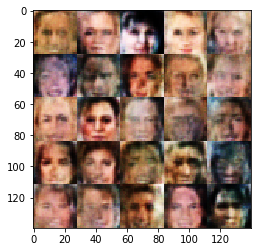

Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.4371
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.4505


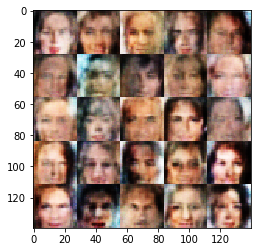

Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.7777
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.9256
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 2.2598
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.8306
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.1986
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.5927


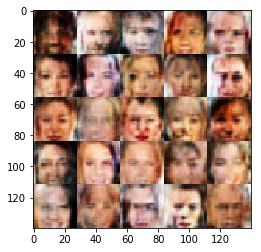

Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.7820
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 2.1869
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 2.0817
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.8863


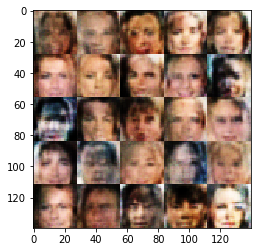

Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.5262
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.7641
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.3860
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.0438


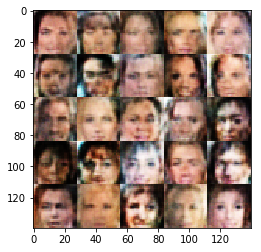

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.7138
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 2.0732
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 2.0005
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.8047
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 2.1447
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.7579


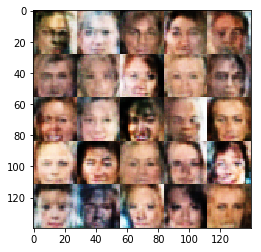

Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.3417
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.3876
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.9475


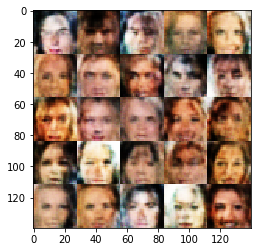

Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.8134


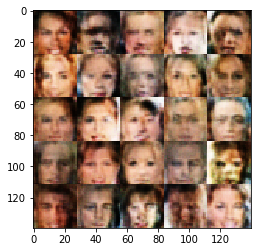

Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.6205


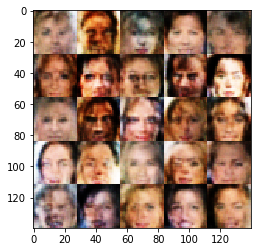

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.4624


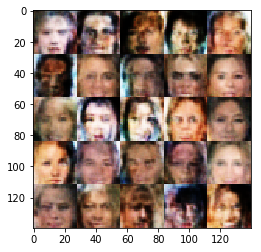

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.3548


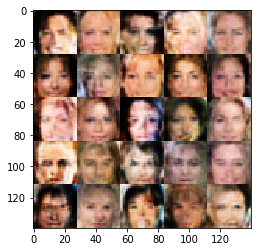

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.3422
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.4011


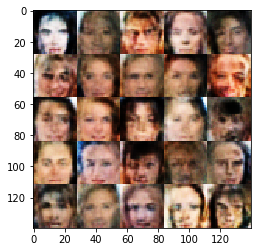

Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.3735
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 0.3302
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.7704


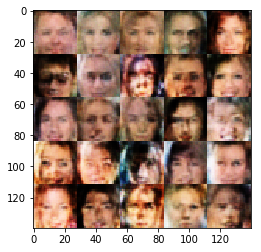

Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.3769
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.3909
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.3962


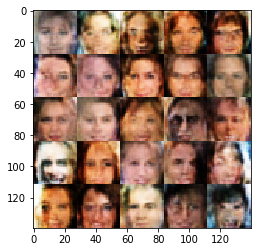

Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.4944


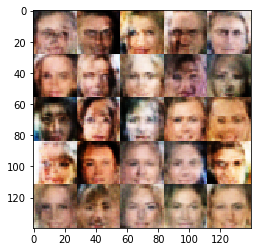

Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.2765
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.5115


In [28]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001  
beta1 = 0.1  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.